In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/saad-3/Microscopic Image Dataset of Plant-Parasitic Nematodes/dataset_readme.md
/kaggle/input/saad-3/Microscopic Image Dataset of Plant-Parasitic Nematodes/dataset_metadata.csv
/kaggle/input/saad-3/Microscopic Image Dataset of Plant-Parasitic Nematodes/Genus Meloidogyne/Meloidogyne (59).jpg
/kaggle/input/saad-3/Microscopic Image Dataset of Plant-Parasitic Nematodes/Genus Meloidogyne/Meloidogyne (181).jpg
/kaggle/input/saad-3/Microscopic Image Dataset of Plant-Parasitic Nematodes/Genus Meloidogyne/Meloidogyne (104).jpg
/kaggle/input/saad-3/Microscopic Image Dataset of Plant-Parasitic Nematodes/Genus Meloidogyne/Meloidogyne (118).jpg
/kaggle/input/saad-3/Microscopic Image Dataset of Plant-Parasitic Nematodes/Genus Meloidogyne/Meloidogyne (47).jpg
/kaggle/input/saad-3/Microscopic Image Dataset of Plant-Parasitic Nematodes/Genus Meloidogyne/Meloidogyne (135).jpg
/kaggle/input/saad-3/Microscopic Image Dataset of Plant-Parasitic Nematodes/Genus Meloidogyne/Meloidogyne (205).jpg

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torch.nn.functional as F
import numpy as np


In [3]:
simclr_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.8, 0.8, 0.8, 0.2),
    transforms.RandomGrayscale(p=0.2),
    transforms.GaussianBlur(kernel_size=9),
    transforms.ToTensor(),
])


In [4]:
class SimCLRDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform):
        self.dataset = datasets.ImageFolder(root=root_dir)
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, _ = self.dataset[idx]
        x1 = self.transform(img)
        x2 = self.transform(img)
        return x1, x2


In [5]:
DATA_DIR = "/kaggle/input/saad-3/Microscopic Image Dataset of Plant-Parasitic Nematodes"

train_dataset = SimCLRDataset(
    root_dir=DATA_DIR,
    transform=simclr_transform
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)


In [6]:
def get_resnet18_encoder():
    resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    resnet.fc = nn.Identity()   # remove final fully connected layer
    return resnet


In [7]:
class ProjectionHead(nn.Module):
    def __init__(self, input_dim=512, proj_dim=128):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, proj_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [8]:
class NT_Xent(nn.Module):
    def __init__(self, batch_size, temperature=0.5):
        super().__init__()
        self.batch_size = batch_size
        self.temperature = temperature
        self.cosine = nn.CosineSimilarity(dim=-1)

    def forward(self, z1, z2):
        batch_size = z1.shape[0]

        z = torch.cat([z1, z2], dim=0)  # 2N

        sim_matrix = self.cosine(z.unsqueeze(1), z.unsqueeze(0)) / self.temperature
        labels = torch.arange(batch_size).cuda()
        labels = torch.cat([labels, labels], dim=0)

        mask = torch.eye(batch_size * 2, device=z.device).bool()
        sim_matrix = sim_matrix.masked_fill(mask, -9e15)

        loss = F.cross_entropy(sim_matrix, labels)
        return loss


In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

encoder = get_resnet18_encoder().to(device)
projector = ProjectionHead().to(device)
criterion = NT_Xent(batch_size=32).to(device)

optimizer = optim.Adam(
    list(encoder.parameters()) + list(projector.parameters()),
    lr=3e-4
)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 218MB/s]


In [10]:
epochs = 50

encoder.train()
projector.train()

for epoch in range(epochs):
    total_loss = 0

    for x1, x2 in train_loader:
        x1 = x1.to(device)
        x2 = x2.to(device)

        h1 = encoder(x1)
        h2 = encoder(x2)

        z1 = projector(h1)
        z2 = projector(h2)

        loss = criterion(z1, z2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs} — Loss: {total_loss/len(train_loader):.4f}")


Epoch 1/50 — Loss: 4500000176340992.0000
Epoch 2/50 — Loss: 4500000176340992.0000
Epoch 3/50 — Loss: 4500000176340992.0000
Epoch 4/50 — Loss: 4500000176340992.0000
Epoch 5/50 — Loss: 4500000176340992.0000
Epoch 6/50 — Loss: 4500000176340992.0000
Epoch 7/50 — Loss: 4500000176340992.0000
Epoch 8/50 — Loss: 4500000176340992.0000
Epoch 9/50 — Loss: 4500000176340992.0000
Epoch 10/50 — Loss: 4500000176340992.0000
Epoch 11/50 — Loss: 4500000176340992.0000
Epoch 12/50 — Loss: 4500000176340992.0000
Epoch 13/50 — Loss: 4500000176340992.0000
Epoch 14/50 — Loss: 4500000176340992.0000
Epoch 15/50 — Loss: 4500000176340992.0000
Epoch 16/50 — Loss: 4500000176340992.0000
Epoch 17/50 — Loss: 4500000176340992.0000
Epoch 18/50 — Loss: 4500000176340992.0000
Epoch 19/50 — Loss: 4500000176340992.0000
Epoch 20/50 — Loss: 4500000176340992.0000
Epoch 21/50 — Loss: 4500000176340992.0000
Epoch 22/50 — Loss: 4500000176340992.0000
Epoch 23/50 — Loss: 4500000176340992.0000
Epoch 24/50 — Loss: 4500000176340992.0000
E

In [11]:
torch.save(encoder.state_dict(), "simclr_resnet18_encoder.pth")
print("Encoder saved!")


Encoder saved!


In [12]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(DATA_DIR, transform=transform)

# Split 80% train, 10% val, 10% test
from torch.utils.data import random_split

test_ratio = 0.1
val_ratio = 0.1

test_size = int(test_ratio * len(dataset))
val_size = int(val_ratio * len(dataset))
train_size = len(dataset) - test_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


Train: 814, Val: 101, Test: 101


In [13]:
num_classes = len(dataset.classes)

class SimCLRClassifier(nn.Module):
    def __init__(self, encoder, num_classes):
        super().__init__()
        self.encoder = encoder
        self.encoder.fc = nn.Identity()  # ensure no final FC
        for param in self.encoder.parameters():
            param.requires_grad = False   # freeze encoder
        self.fc = nn.Linear(512, num_classes)  # 512 = ResNet18 feature dim

    def forward(self, x):
        features = self.encoder(x)
        out = self.fc(features)
        return out

device = "cuda" if torch.cuda.is_available() else "cpu"
encoder.load_state_dict(torch.load("simclr_resnet18_encoder.pth"))
model = SimCLRClassifier(encoder, num_classes).to(device)


In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)  # only train classifier


In [15]:
epochs = 50

for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    train_loss = running_loss / total

    # Validation
    model.eval()
    val_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_acc = correct / total
    val_loss = val_loss / total

    print(f"Epoch {epoch+1}/{epochs} — Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")


Epoch 1/50 — Train Loss: 1.9146, Train Acc: 0.3256 | Val Loss: 1.6181, Val Acc: 0.3762
Epoch 2/50 — Train Loss: 1.3875, Train Acc: 0.5086 | Val Loss: 1.3493, Val Acc: 0.5149
Epoch 3/50 — Train Loss: 1.2345, Train Acc: 0.5565 | Val Loss: 1.2891, Val Acc: 0.5248
Epoch 4/50 — Train Loss: 1.1893, Train Acc: 0.5811 | Val Loss: 1.2430, Val Acc: 0.5248
Epoch 5/50 — Train Loss: 1.1162, Train Acc: 0.6069 | Val Loss: 1.2224, Val Acc: 0.5149
Epoch 6/50 — Train Loss: 1.0719, Train Acc: 0.6081 | Val Loss: 1.1866, Val Acc: 0.5446
Epoch 7/50 — Train Loss: 1.0666, Train Acc: 0.5995 | Val Loss: 1.2044, Val Acc: 0.5743
Epoch 8/50 — Train Loss: 1.0377, Train Acc: 0.6265 | Val Loss: 1.1742, Val Acc: 0.5545
Epoch 9/50 — Train Loss: 1.0194, Train Acc: 0.6265 | Val Loss: 1.1989, Val Acc: 0.5347
Epoch 10/50 — Train Loss: 1.0200, Train Acc: 0.6241 | Val Loss: 1.2265, Val Acc: 0.5149
Epoch 11/50 — Train Loss: 0.9840, Train Acc: 0.6388 | Val Loss: 1.2343, Val Acc: 0.4950
Epoch 12/50 — Train Loss: 0.9417, Train A

In [16]:
model.eval()  # 1️⃣ Set model to evaluation mode (turns off dropout, batchnorm updates)
correct, total = 0, 0
all_preds, all_labels = [], []

with torch.no_grad():  # 2️⃣ Disable gradient computation to save memory
    for images, labels in test_loader:  # 3️⃣ Loop over test batches
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)  # 4️⃣ Forward pass
        _, preds = torch.max(outputs, 1)  # 5️⃣ Get predicted class (argmax)
        
        # 6️⃣ Collect all predictions and labels for further metrics
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        # 7️⃣ Count correct predictions for accuracy
        correct += (preds == labels).sum().item()
        total += labels.size(0)

# 8️⃣ Compute final test accuracy
test_acc = correct / total
print(f"\n✅ Test Accuracy: {test_acc*100:.2f}%")




✅ Test Accuracy: 70.30%



Classification Report:
                       precision    recall  f1-score   support

  Genus Criconemoides       0.91      1.00      0.95        10
Genus Helicotylenchus       0.89      0.77      0.83        22
Genus Hemicycliophora       0.00      0.00      0.00         2
 Genus Hirschmaniella       0.43      0.38      0.40         8
    Genus Hoplolaimus       0.64      0.64      0.64        11
    Genus Meloidogyne       0.72      0.75      0.74        28
   Genus Pratylenchus       0.46      0.60      0.52        10
     Genus Radopholus       0.67      1.00      0.80         2
    Genus Trichodorus       0.50      0.67      0.57         3
      Genus Xiphinema       0.75      0.60      0.67         5

             accuracy                           0.70       101
            macro avg       0.60      0.64      0.61       101
         weighted avg       0.70      0.70      0.70       101



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


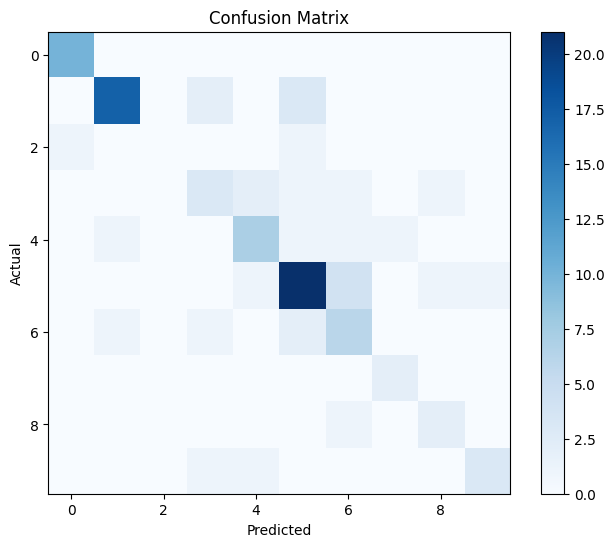

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

unique_labels = sorted(list(set(all_labels)))
target_names = [dataset.classes[i] for i in unique_labels]

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=target_names))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar()
plt.show()
